In [22]:
import numpy as np
#import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import itertools
import random
import sys

In [294]:
def unpack3(d,i):
    return (math.floor(i/(d*d)), math.floor(i/d) % d, i % d)

def pack3(d,t):
    return d*d*t[0] + d*t[1] + t[2]

def tuple3swap23(t):
    return (t[0], t[2], t[1])

def orth(M):
    #return scipy.linalg.orth(M)
    q,r = np.linalg.qr(M.T)
    eps = matrix_machine_epsilon(M)
    return np.array([qv for (qv, rv) in zip(q.T,r) if np.linalg.norm(rv) > eps])

def unit_vec(a):
    return a / np.linalg.norm(a)

def matrix_machine_epsilon(M):
    return 10 * np.finfo(M.dtype).eps * max(M.shape) * np.linalg.norm(M)

def trial(n, d, random_generator=np.random.randn, verbose=False):
    P23 = [[1 if unpack3(d,i) == tuple3swap23(unpack3(d,j)) else 0 for i in range(d*d*d)] for j in range(d*d*d)]
    if verbose: print("n,d: " + str(n) + "," + str(d))
    A = random_generator(n,d)
    A = np.array([unit_vec(ai) for ai in A])
    if verbose: print(A.shape)
    AA = np.array([np.kron(ai,ai) for ai in A])
    if verbose: print(AA.shape)
    AAB = np.vstack([np.kron(aiai, orth(np.identity(d) - np.outer(ai,ai))) for (aiai, ai) in zip(AA, A)])
    if verbose: print(AAB.shape)
    OrthAAB = orth(AAB)
    HalfIdMinusP23OrthAAB = (OrthAAB - np.dot(OrthAAB, P23))/2
    u, s, vh = np.linalg.svd(HalfIdMinusP23OrthAAB)
    if verbose: print(s)
    if verbose: print(len(s))
    if verbose: print("Kappa: " + str(min(s)))
    sA = np.linalg.svd(A)[1]
    if verbose: print(len(sA))
    if verbose: print("||A||: " + str(max(sA)))
    if verbose: print("||A^-1||^-1: " + str(min(sA)))
    sAA = np.linalg.svd(AA)[1]
    if verbose: print(len(sAA))
    if verbose: print("||AA||: " + str(max(sAA)))
    if verbose: print("||AA^-1||^-1: " + str(min(sAA)))
    return (min(s), min(sAA), max(sAA))

# testing individual trials

In [291]:
trial(2, 6, random_generator=(lambda n,d: rand_sparse_vectors(n,d,5)), verbose=True)

n,d: 2,6
(2, 6)
(2, 36)
(10, 216)
[0.76672405 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
 0.70710678 0.70710678 0.70710678 0.64113329]
10
Kappa: 0.6411332862058929
2
||A||: 1.087625199177916
||A^-1||^-1: 0.9039200330301337
2
||AA||: 1.0165937552160442
||AA^-1||^-1: 0.9831262059653076


In [156]:
print(rand_sparse_vectors(20,10,2))

[[ 0.          0.6801728   0.          0.          0.          0.
   0.          0.         -0.50209345  0.        ]
 [ 0.          0.          0.         -1.79206445  0.          0.0767937
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.1878403   0.
   0.          0.14176238  0.          0.        ]
 [ 0.          0.          0.06369083  0.          0.          0.
   0.          0.         -0.47367528  0.        ]
 [ 0.          0.          0.04717216  0.          0.          0.
   0.2800775   0.          0.          0.        ]
 [ 0.          0.          0.         -0.03458636  0.14802339  0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.93668048  0.         -1.05609664  0.
   0.          0.          0.          0.        ]
 [ 0.         -0.98491979  0.          0.          0.          0.
   0.         -0.37757212  0.          0.        ]
 [ 0.         -1.44468698  0.          0.          0.    

In [292]:
def elementary(n, d):
    A = np.zeros((n,d))
    for i in range(n):
        A[i][i] = 1
    return A
    
trial(2, 3, random_generator=elementary, verbose=True)
#trial(2, 3, verbose=True)

n,d: 2,3
(2, 3)
(2, 9)
(4, 27)
[0.70710678 0.70710678 0.70710678 0.70710678]
4
Kappa: 0.7071067811865476
2
||A||: 1.0
||A^-1||^-1: 1.0
2
||AA||: 1.0
||AA^-1||^-1: 1.0


# data generation and plotting logic

In [315]:
def generate_data(dd, nn, samples, random_generator=np.random.randn):
    trials = [[
        (sys.stdout.write("\rn=%d, d=%d, trial %d of %d" % (n, d, i+1, samples)),
         trial(n, d, random_generator))[1]
        for i in range(samples)] for (n,d) in zip(nn,dd)]
    sys.stdout.write('\r')
    kappa = [statistics.median([t[0] for t in s]) for s in trials]
    AAmin = [statistics.median([t[1] for t in s]) for s in trials]
    AAmax = [statistics.median([t[2] for t in s]) for s in trials]
    df = pd.DataFrame({"d": dd, "n": nn, "kappa": kappa, "||AA||": AAmax, "sigmamin(AA)": AAmin})
    return df

def draw_plot(df, title, vs="d", log=False):
    p = plt.semilogy if log else plt.plot
    p( vs, 'kappa', data=df, marker='o', markerfacecolor='blue', markersize=6, color='blue', linewidth=2)
    #p( vs, '||AA||', data=df, marker='', color='red', linewidth=2, linestyle='dashed')
    p( vs, 'sigmamin(AA)', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
    plt.xlabel(vs)
    plt.title(title)
    plt.legend()
    plt.show()
    
def make_figure(dd, nn, samples, title, plot_vs, log=False):
    df = generate_data(dd, nn, samples)
    draw_plot(df, title, plot_vs, log)

In [4]:
def draw_plot_different_d_series(dfs, ds, title, log=False):
    p = plt.semilogy if log else plt.plot
    for (df, d) in zip(dfs, ds):
        p('n', 'kappa', data=df, marker='o', linewidth=2, label="d = " + str(d))
    plt.xlabel("n")
    plt.ylabel("κ")
    plt.legend()
    plt.show()
    
def draw_plot_different_d_series_quadratic_n(dfs, ds, title, log=False):
    p = plt.semilogy if log else plt.plot
    for (df, d) in zip(dfs, ds):
        df.loc[:,'n/d^2'] = df.loc[:,'n'] / df.loc[:,'d'] / df.loc[:,'d']
        p('n/d^2', 'kappa', data=df, marker='o', linewidth=2, label="d = " + str(d))
    plt.xlabel("n/d²")
    plt.ylabel("κ")
    plt.title(title)
    plt.legend()
    plt.show()

# plots!

### plots against d with n varying quadratically

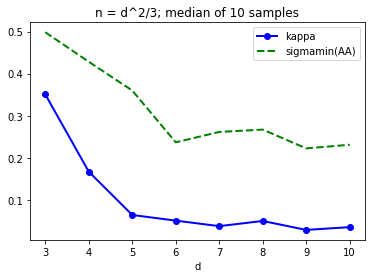

In [124]:
dd = range(3, 10+1)
nn = [math.floor(d ** 2 / 3) for d in dd]
make_figure(dd, nn, 10, "n = d^2/3; median of 10 samples", "d", log=False)

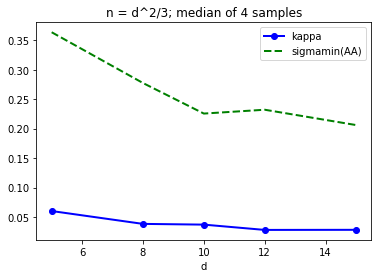

In [120]:
dd = [5, 8, 10, 12, 15]#, 17, 20]
nn = [math.floor(d ** 2 / 3) for d in dd]
make_figure(dd, nn, 4, "n = d^2/3; median of 4 samples", "d", log=False)

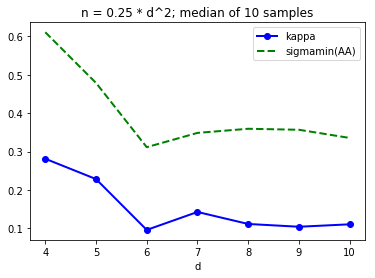

In [125]:
dd = range(4, 10+1)
nn = [math.floor(0.25 * d ** 2 ) for d in dd]
make_figure(dd, nn, 10, "n = 0.25 * d^2; median of 10 samples", "d", log=False)

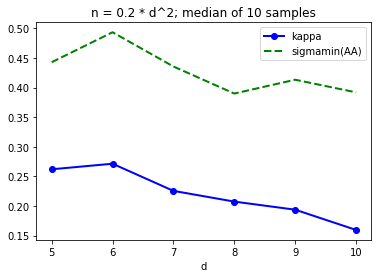

In [127]:
dd = range(5, 10+1)
nn = [math.floor(0.2 * d ** 2 ) for d in dd]
make_figure(dd, nn, 10, "n = 0.2 * d^2; median of 10 samples", "d", log=False)

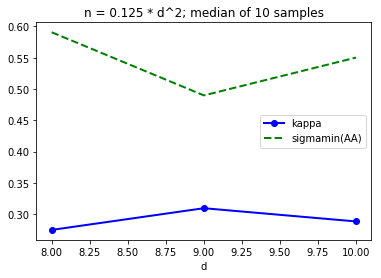

In [128]:
dd = range(8, 10+1)
nn = [math.floor(0.125 * d ** 2 ) for d in dd]
make_figure(dd, nn, 10, "n = 0.125 * d^2; median of 10 samples", "d", log=False)

In [ ]:
dd = [5, 8, 10, 12, 15, 17, 20]
nn = [math.floor(d ** 2 / 4) for d in dd]
make_figure(dd, nn, 4, "n = d^2/4; median of 4 samples", "d", log=False)

### plots against n

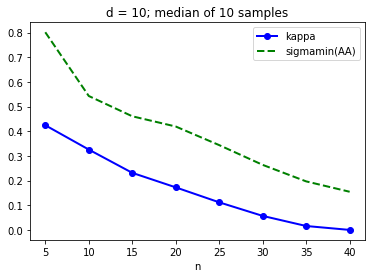

In [129]:
nn = [5, 10, 15, 20, 25, 30, 35, 40]
dd = [10 for n in nn]
make_figure(dd, nn, 10, "d = 10; median of 10 samples", "n", log=False)

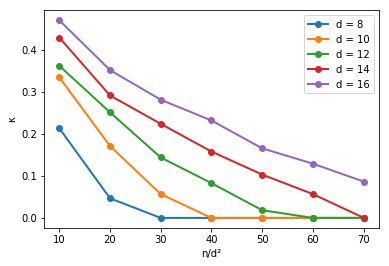

In [25]:
ds = [8, 10, 12, 14, 16]
dfs = []
for d in ds:
    nn = [10, 20, 30, 40, 50, 60, 70]
    dd = [d for n in nn]
    df = generate_data(dd, nn, 4)
    dfs = dfs + [df]
draw_plot_different_d_series(dfs, ds, "κ as a function of d and n; median of 4 samples")

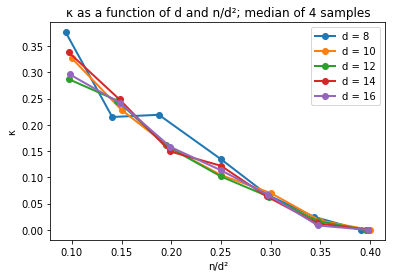

In [24]:
ds = [8, 10, 12, 14, 16]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]]
    dd = [d for n in nn]
    df = generate_data(dd, nn, 4)
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; median of 4 samples")

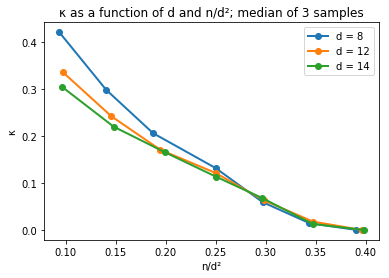

In [22]:

draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; median of 3 samples")
#dfs[0].loc[:,'n']

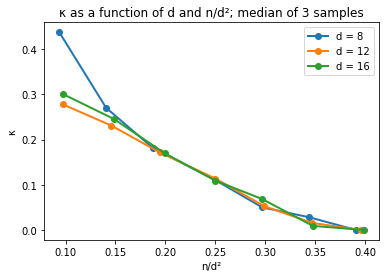

In [28]:
ds = [8, 12, 16]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]]
    dd = [d for n in nn]
    df = generate_data(dd, nn, 3)
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; median of 3 samples")

# plots for random vectors from different distributions

In [309]:
def rand_sparse_vectors(n, d, k):
    A = np.zeros((n,d))
    for i in range(n):
        S = random.sample(range(d), k)
        for j in S:
            A[i][j] = random.gauss(0, 1)
    return A
def rand_hamming_vectors(n, d):
    A = np.zeros((n,d))
    for i in range(n):
        while sum(A[i,]) == 0:
            A[i,] = np.random.randint(0, 2, size=d)
    return A
def rand_vectors_one_high_covar_dir(n, d, mag=1/2):
    zeros = np.zeros(d)
    iden = np.identity(d)
    spike = unit_vec(np.random.multivariate_normal(zeros, iden))
    cov = iden + mag * d * np.outer(spike, spike)
    return np.random.multivariate_normal(zeros, cov, size=n)
def rand_vectors_3_high_and_low_covar_dirs(n, d):
    zeros = np.zeros(d)
    iden = np.identity(d)
    spikes = [unit_vec(np.random.multivariate_normal(zeros, iden)) for _ in range(3)]
    dips = [unit_vec(np.random.multivariate_normal(zeros, iden)) for _ in range(3)]
    cov = iden + sum([(d/3) * np.outer(spike, spike) for spike in spikes]) - sum([(1 - 1/(d/3)) * np.outer(dip, dip) for dip in dips])
    return np.random.multivariate_normal(zeros, cov, size=n)


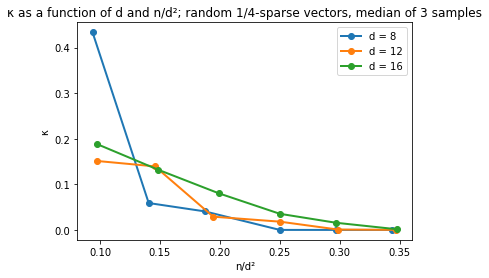

In [304]:

ds = [8, 12, 16]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]]
    dd = [d for n in nn]
    df = generate_data(dd, nn, 3, random_generator=(lambda n,d: rand_sparse_vectors(n,d,d//4)))
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; random 1/4-sparse vectors, median of 3 samples")

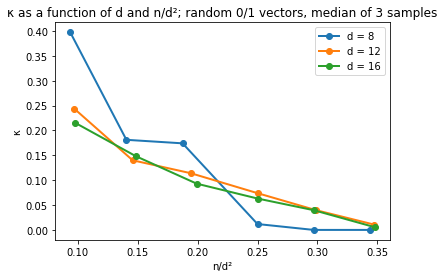

In [303]:

ds = [8, 12, 16]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]]
    dd = [d for n in nn]
    df = generate_data(dd, nn, 3, rand_hamming_vectors)
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; random 0/1 vectors, median of 3 samples")

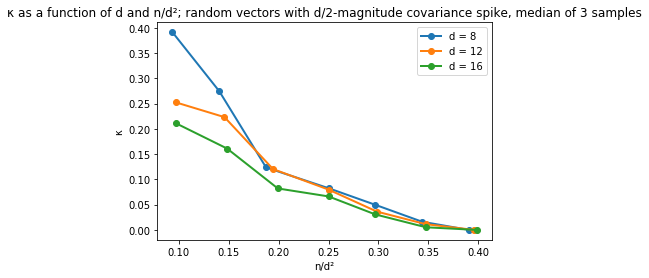

In [211]:

ds = [8, 12, 16]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]]
    dd = [d for n in nn]
    try:
        df = generate_data(dd, nn, 3, rand_vectors_one_high_covar_dir)
    except np.linalg.LinAlgError:
        print("LinAlgError; trying again.")
        df = generate_data(dd, nn, 3, rand_vectors_one_high_covar_dir)
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; random vectors with d/2-magnitude covariance spike, median of 3 samples")


n=9, d=8, trial 3 of 3

/home/jshi/tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  import sys


n=76, d=16, trial 1 of 3LinAlgError; trying again.


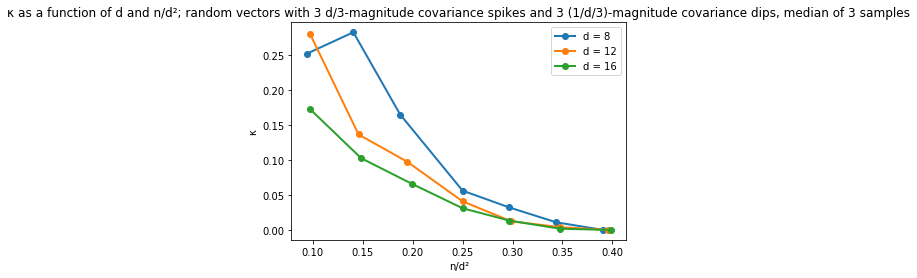

In [214]:

ds = [8, 12, 16]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]]
    dd = [d for n in nn]
    try:
        df = generate_data(dd, nn, 3, rand_vectors_3_high_and_low_covar_dirs)
    except np.linalg.LinAlgError:
        print("LinAlgError; trying again.")
        df = generate_data(dd, nn, 3, rand_vectors_3_high_and_low_covar_dirs)
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; random vectors with 3 d/3-magnitude covariance spikes and 3 (1/d/3)-magnitude covariance dips, median of 3 samples")


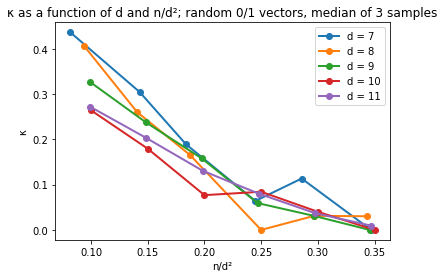

In [302]:
ds = [7, 8, 9, 10, 11]
dfs = []
for d in ds:
    nn = [math.floor(c*d*d) for c in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]]
    dd = [d for n in nn]
    df = generate_data(dd, nn, 3, rand_hamming_vectors)
    dfs = dfs + [df]
draw_plot_different_d_series_quadratic_n(dfs, ds, "κ as a function of d and n/d²; random 0/1 vectors, median of 3 samples")

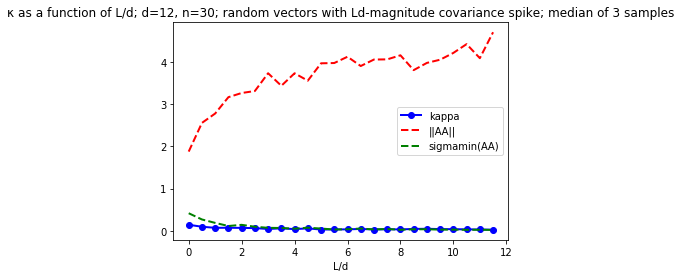

In [314]:
dfs = pd.DataFrame()
mags = [0.5 * i for i in range(24)]
for mag in mags:
    rand_vec = lambda n,d: rand_vectors_one_high_covar_dir(n,d,mag)
    try:
        df = generate_data([12], [30], 3, rand_vec)
    except np.linalg.LinAlgError:
        print("LinAlgError; trying again.")
        df = generate_data([12], [30], 3, rand_vec)
    df.loc[:, 'L/d'] = mag
    dfs = pd.concat([dfs, df])
draw_plot(dfs, "κ as a function of L/d; d=12, n=30; random vectors with Ld-magnitude covariance spike; median of 3 samples", vs='L/d')


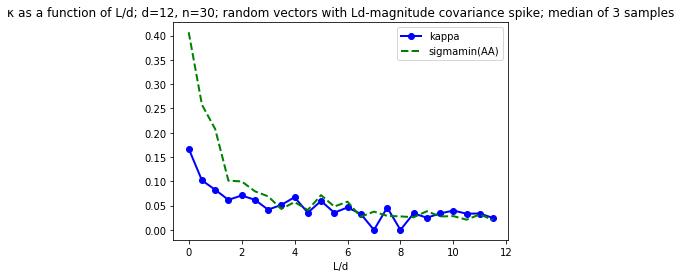

In [316]:
dfs = pd.DataFrame()
mags = [0.5 * i for i in range(24)]
for mag in mags:
    rand_vec = lambda n,d: rand_vectors_one_high_covar_dir(n,d,mag)
    try:
        df = generate_data([12], [30], 3, rand_vec)
    except np.linalg.LinAlgError:
        print("LinAlgError; trying again.")
        df = generate_data([12], [30], 3, rand_vec)
    df.loc[:, 'L/d'] = mag
    dfs = pd.concat([dfs, df])
draw_plot(dfs, "κ as a function of L/d; d=12, n=30; random vectors with Ld-magnitude covariance spike; median of 3 samples", vs='L/d')


In [317]:
draw_plot(dfs, "κ as a function of L/d; d=12, n=30; random vectors with Ld-magnitude covariance spike; median of 3 samples", vs='L/d', log=True)


In [318]:
dfs = pd.DataFrame()
mags = [12 + 0.5 * i for i in range(24)]
for mag in mags:
    rand_vec = lambda n,d: rand_vectors_one_high_covar_dir(n,d,mag)
    try:
        df = generate_data([12], [30], 3, rand_vec)
    except np.linalg.LinAlgError:
        print("LinAlgError; trying again.")
        df = generate_data([12], [30], 3, rand_vec)
    df.loc[:, 'L/d'] = mag
    dfs = pd.concat([dfs, df])

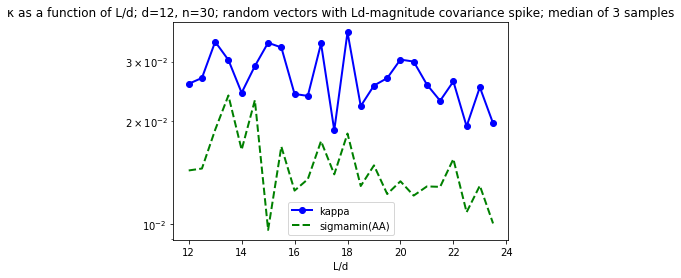

In [319]:
draw_plot(dfs, "κ as a function of L/d; d=12, n=30; random vectors with Ld-magnitude covariance spike; median of 3 samples", vs='L/d')
draw_plot(dfs, "κ as a function of L/d; d=12, n=30; random vectors with Ld-magnitude covariance spike; median of 3 samples", vs='L/d', log=True)
